## 1. Calibration

RETURN:
 0.1370470936872424
CAMERA_MATRIX:
 [[461.91776815   0.         257.02652118]
 [  0.         447.51630544 218.65841729]
 [  0.           0.           1.        ]]
DISTORTION:
 [[ 0.14497122 -0.0349204  -0.00454199 -0.01589941 -0.0887708 ]]
ROTATION:
 (array([[-0.26305009],
       [ 0.16510265],
       [ 3.09573949]]), array([[-0.26305009],
       [ 0.16510265],
       [ 3.09573949]]))
TRANSLATION:
 (array([[ 7.36896023],
       [ 2.93698059],
       [12.07531535]]), array([[ 7.36896023],
       [ 2.93698059],
       [12.07531535]]))


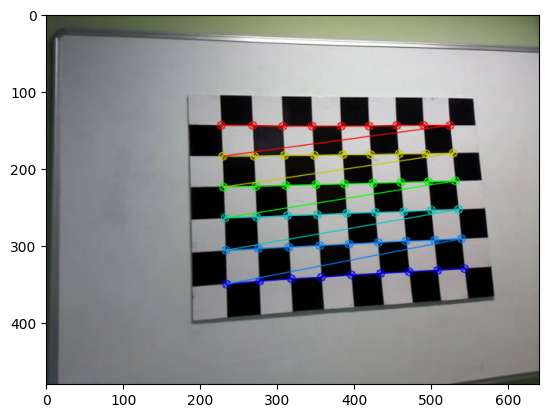

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import glob

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

grid_size = (9, 6)
objp = np.zeros((grid_size[0] * grid_size[1],3), np.float32)
objp[:,:2] = np.mgrid[0:grid_size[0],0:grid_size[1]].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('calib_[0-9].jpg')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, grid_size, None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, grid_size, corners2, ret)
        plt.imshow(img)

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print("RETURN:\n", ret)
print("CAMERA_MATRIX:\n", mtx)
print("DISTORTION:\n", dist)
print("ROTATION:\n", rvecs)
print("TRANSLATION:\n", tvecs)

In [3]:
import numpy as np
import cv2 as cv

def calibrate_camera(grid_x, grid_y, size_x, size_y, images):
    """
    Calibrate camera using chessboard images.
    
    Parameters:
    grid_x (int): Number of inner corners along x direction
    grid_y (int): Number of inner corners along y direction
    size_x (float): Physical size of the grid in x direction (per square)
    size_y (float): Physical size of the grid in y direction (per square)
    images (list): List of images as numpy arrays
    
    Returns:
    tuple: (ret, mtx, dist, rvecs, tvecs)
        ret: RMS re-projection error
        mtx: Camera matrix (3x3)
        dist: Distortion coefficients
        rvecs: Rotation vectors
        tvecs: Translation vectors
    """
    # Termination criteria for cornerSubPix
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    # Prepare object points
    grid_size = (grid_x, grid_y)
    objp = np.zeros((grid_size[0] * grid_size[1], 3), np.float32)
    
    # Create grid of points with actual physical dimensions
    x_coords = np.linspace(0, size_x * (grid_x - 1), grid_x)
    y_coords = np.linspace(0, size_y * (grid_y - 1), grid_y)
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)
    objp[:,:2] = np.column_stack((x_grid.flatten(), y_grid.flatten()))
    
    # Arrays to store object points and image points
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane
    
    for img in images:
        # Convert to grayscale
        if len(img.shape) == 3:
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        else:
            gray = img
            
        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, grid_size, None)
        
        if ret:
            objpoints.append(objp)
            # Refine corners to sub-pixel accuracy
            corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners2)
    
    # Perform camera calibration
    if len(objpoints) > 0:
        return cv.calibrateCamera(
            objpoints,
            imgpoints,
            gray.shape[::-1],  # image size (width, height)
            None,
            None
        )
    else:
        raise ValueError("No valid calibration patterns found in the provided images")

In [46]:
images = [cv.imread(fname)for file in glob.glob('calib_[0-9].jpg')]
ret, mtx, dist, rvecs, tvecs = calibrate_camera(9, 6, 1.0, 1.0, images)
print("RETURN:\n", ret)
print("CAMERA_MATRIX:\n", mtx)
print("DISTORTION:\n", dist)
print("ROTATION:\n", rvecs)
print("TRANSLATION:\n", tvecs)

RETURN:
 0.1370470936872424
CAMERA_MATRIX:
 [[461.91776815   0.         257.02652118]
 [  0.         447.51630544 218.65841729]
 [  0.           0.           1.        ]]
DISTORTION:
 [[ 0.14497122 -0.0349204  -0.00454199 -0.01589941 -0.0887708 ]]
ROTATION:
 (array([[-0.26305009],
       [ 0.16510265],
       [ 3.09573949]]), array([[-0.26305009],
       [ 0.16510265],
       [ 3.09573949]]))
TRANSLATION:
 (array([[ 7.36896023],
       [ 2.93698059],
       [12.07531535]]), array([[ 7.36896023],
       [ 2.93698059],
       [12.07531535]]))


In [69]:
rvecs

(array([[-0.26305009],
        [ 0.16510265],
        [ 3.09573949]]),
 array([[-0.26305009],
        [ 0.16510265],
        [ 3.09573949]]))

In [10]:
def display_calibration_results(grid_x, grid_y, mtx, dist, rvecs, tvecs, images):
    """
    Display calibration results by showing detected corners for each image.
    
    Parameters:
    images (list): List of input images as numpy arrays
    grid_x (int): Number of inner corners along x direction
    grid_y (int): Number of inner corners along y direction
    mtx (np.ndarray): Camera matrix from calibration
    dist (np.ndarray): Distortion coefficients from calibration
    rvecs (list): Rotation vectors from calibration
    tvecs (list): Translation vectors from calibration
    """
    grid_size = (grid_x, grid_y)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    # Set up the plotting
    n_images = len(images)
    n_cols = min(3, n_images)  # Maximum 3 images per row
    n_rows = (n_images + n_cols - 1) // n_cols
    fig = plt.figure(figsize=(6*n_cols, 4*n_rows))
    
    for idx, img in enumerate(images):
        # Convert to grayscale for corner detection
        if len(img.shape) == 3:
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        else:
            gray = img
            img = cv.cvtColor(gray, cv.COLOR_GRAY2BGR)
            
        # Find and refine chessboard corners
        ret, corners = cv.findChessboardCorners(gray, grid_size, None)
        
        if ret:
            # Refine corners
            corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
            
            # Draw corners
            img_copy = img.copy()
            cv.drawChessboardCorners(img_copy, grid_size, corners2, ret)
            
            # Calculate reprojection error for this image
            objp = np.zeros((grid_size[0] * grid_size[1], 3), np.float32)
            objp[:,:2] = np.mgrid[0:grid_size[0], 0:grid_size[1]].T.reshape(-1,2)
            
            # Project 3D points to image plane
            imgpoints2, _ = cv.projectPoints(objp, rvecs[idx], tvecs[idx], mtx, dist)
            error = cv.norm(corners2, imgpoints2, cv.NORM_L2) / len(imgpoints2)
            
            # Display the image
            plt.subplot(n_rows, n_cols, idx + 1)
            if img_copy.shape[2] == 3:
                plt.imshow(cv.cvtColor(img_copy, cv.COLOR_BGR2RGB))
            else:
                plt.imshow(img_copy, cmap='gray')
            plt.title(f'Image {idx+1}\nRe-projection error: {error:.3f} pixels')
            plt.axis('off')
        else:
            plt.subplot(n_rows, n_cols, idx + 1)
            plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
            plt.title(f'Image {idx+1}\nNo corners detected')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print overall calibration results
    print("Camera Matrix:")
    print(mtx)
    print("\nDistortion Coefficients:")
    print(dist)


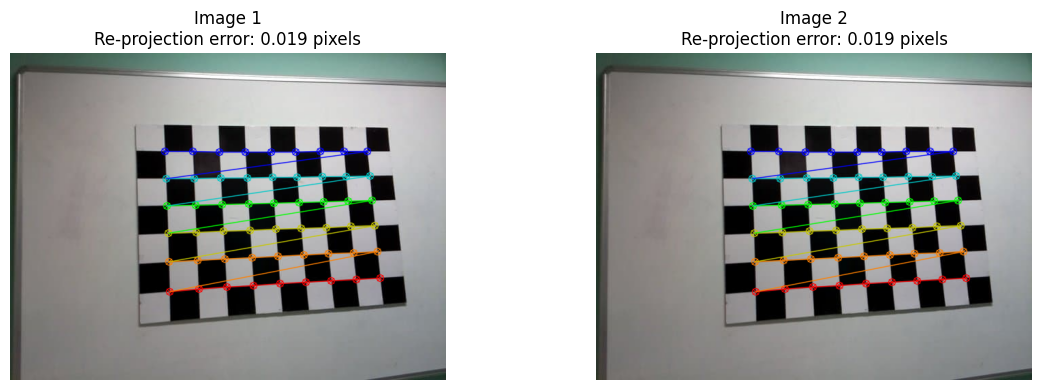

Camera Matrix:
[[461.91776815   0.         257.02652118]
 [  0.         447.51630544 218.65841729]
 [  0.           0.           1.        ]]

Distortion Coefficients:
[[ 0.14497122 -0.0349204  -0.00454199 -0.01589941 -0.0887708 ]]


In [11]:
display_calibration_results(images, 9, 6, mtx, dist, rvecs, tvecs)

## 2. Undistort image and pixels

Given a list of `[(image height, image width), (pixel coords)]`, calculate the list of undistorted points with `undistortPoints`

In [53]:
h, w, = images[0].shape[:2]
print(h, w)
h, w = 500, 500
(cv.undistortPoints(np.array([[0.0, 0], 
                                   [h, 0], 
                                   [0, w], 
                                   [h, w],
                                   [mtx[0, 2], mtx[1, 2]]]), mtx, dist)).shape

480 640


(5, 1, 2)

In [80]:
def pixels_to_rays(pixels, mtx, dist):
    ideal_points = cv.undistortPoints(pixels, mtx, dist)
    homogeneous_coords = cv.convertPointsToHomogeneous(ideal_points)
    return np.split(homogeneous_coords, homogeneous_coords.shape[0], axis=0)


camera_rays = pixels_to_rays(np.array([[0.0, 0], 
                                   [h, 0], 
                                   [0, w], 
                                   [h, w],
                                   [mtx[0, 2], mtx[1, 2]]]), mtx, dist)
print(camera_rays)


[array([[[-0.51232747, -0.45399403,  1.        ]]]), array([[[ 0.5132681 , -0.46781111,  1.        ]]]), array([[[-0.51272319,  0.59224073,  1.        ]]]), array([[[0.51904572, 0.61134731, 1.        ]]]), array([[[0., 0., 1.]]])]


In [14]:
def undistort_images(images, mtx, dist):
    new_camera_mtxes, dists, rois, undistorted_images = [], [], [], []
    for img in images:
        h,  w = img.shape[:2]

        # undistort image
        new_camera_mtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
        undistorted_image = cv.undistort(img, mtx, dist, None, new_camera_mtx)
        
        new_camera_mtxes.append(new_camera_mtx)
        dists.append(dist)
        rois.append(roi)
        undistorted_images.append(undistorted_image)

    return new_camera_mtxes, dists, rois, undistorted_images

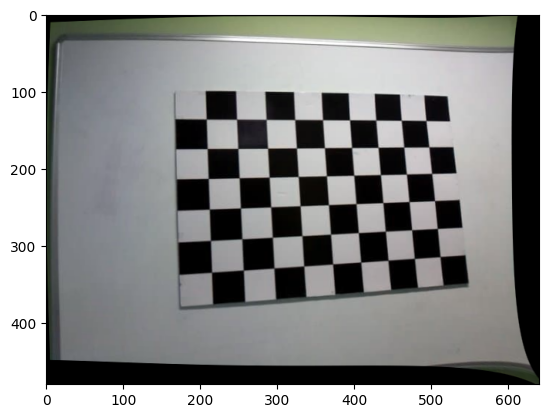

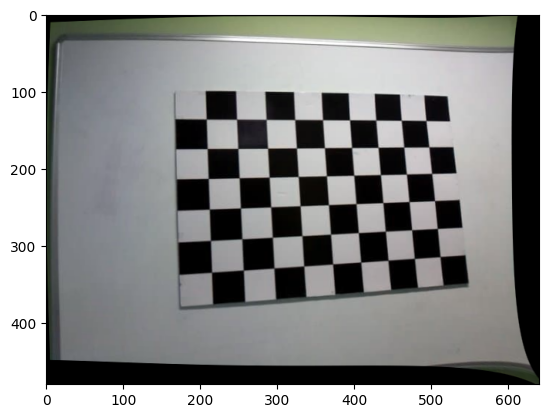

In [16]:
_, _, _, undistorted_images = undistort_images(images, mtx, dist)
for img in undistorted_images:
    plt.imshow(img)
    plt.show()

## 3. Backproject

Given rays in camera frame, and the camera's extrinsic matrix $[R, t]$, return the list of rays.

In [83]:
cv.Rodrigues(np.array([0.0, 0, 0]))

(array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([[ 0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.],
        [ 0., -1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]]))

In [84]:
def map_rays_from_camera_to_ground(camera_rays, rvecs, tvecs):
    positions, directions = [], []
    for i in range(len(camera_rays)):
        camera_ray, rvec, tvec = camera_rays[i], rvecs[i], tvecs[i]
        camera_ray = camera_ray.squeeze()
        R, _ = cv.Rodrigues(camera_ray)
        position = -R.transpose() @ tvec
        direction = R.transpose() @ camera_ray
        direction = direction / np.linalg.norm(direction)
        positions.append(position)
        directions.append(direction)
    return positions, directions

## 4. Intersect with the ground

Given a list of rays and some GIS stuff, find its intersection with the ground.

In [99]:
def ground_intersections(positions, directions):
    ground_positions = []
    for i in range(len(positions)):
        position, direction = positions[i], directions[i]
        direction = direction / np.linalg.norm(direction)
        
        alpha = -position[2]/direction[2]
        ground_position = (position + alpha * direction)[:2]
        ground_positions.append(ground_position)
    return ground_positions

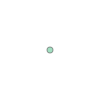

In [90]:
from shapely import Point, LineString

point = Point(2.2, 4.2)
point3D = Point(9.26, -2.456, 0.57)
point3D


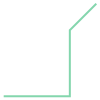

In [95]:
a = LineString([[0, 0, 0], [1, 0, 0], [1, 1, 0], [1.4,1.4,1]])
a